# A Visual Representation of COS Ambassador Data 
----
### Center for Open Science Ambassadors are a global network of over 200 advocates increasing conversations around open science and promoting open science initiatives.


-----
#### **Libraries I'm using in this notebook** 


* Matplotlib

* Pandas

* Numpy

* Basemap

* Geopy

* Folium 

-----
#### Import libraries 

In [1]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json


In [15]:
#let's read our file 
df = pd.read_csv('ambassadors_list.csv')

#drop unecessary columns that I don't need
df.drop(['First Name', 'Last Name', 'Email', 'Mailing Address', 'Prereg Challenge', 'ambassador training date'], axis=1, inplace=True)

#replace cells containing 'NaN' with a blank string (it looks prettier)
df = df.fillna('')

#add column labeled Full Address which combines City, State, and Country
#use numpy conditional statement to account for 'blank' State cells
df['Full Address'] = np.where(df['State'] == '', df['City'] + ', ' + df['Country'], df['City'] + ', ' + df['State'] + ', ' + df['Country'])

#let's see what our data look like 
df.head()

,City,State,Country,Region,Institution/Organization,Domain,Full Address
0,Bonn,,Germany,Europe,MPI Collective Goods,Psychology,"Bonn, Germany"
1,Eindhoven,,Netherlands,Europe,Eindhoven,Psychology,"Eindhoven, Netherlands"
2,Grenoble,,France,Europe,Université Grenoble Alpes,Psychology,"Grenoble, France"
3,Riverside,California,USA,North America,University of California - Riverside,Psychology,"Riverside, California, USA"
4,Tacoma,Washington,USA,North America,Pacific Lutheran,Psychology,"Tacoma, Washington, USA"


In [3]:
#make a list out of the Full Address column. This list will be used when we geocode Ambassador locations
dfToList = df['Full Address'].tolist()

### Let's Do Geocoding! 
My original csv file of Ambassador data lists their location in 'city', 'state', 'country' form. In order to plot points on a map, having the coordinates (latitude and longitude) of each location are important. 

In [4]:
with open ('google_credentials.json') as creds:
    google_credentials = json.load(creds)

In [6]:
from geopy import geocoders
g = geocoders.GoogleV3(google_credentials['api_key']) #you need a GoogleV3 API key

#create empty lists for latitude and longitude
lats = []
lons = []
   
for i in dfToList:
    location = g.geocode(i, timeout=10)
    lats.append(location.latitude)
    lons.append(location.longitude)


In [7]:
#add longitudes and latitudes to my table 
df['Longitude'] = lons
df['Latitude'] = lats

#change order of columns (because I am perfectionist and want things in a certain order)
df = df[['City', 'State', 'Country', 'Full Address', 'Longitude', 'Latitude', 'Region', 'Institution/Organization', 'Domain']]

#save table to new CSV file and remove the Index from CSV file (you don't have to do this step)
df.to_csv('ambassadors_list_shortened.csv', index=False)

#let's see what our data look like
df.head()

,City,State,Country,Full Address,Longitude,Latitude,Region,Institution/Organization,Domain
0,Bonn,,Germany,"Bonn, Germany",7.098207,50.737430,Europe,MPI Collective Goods,Psychology
1,Eindhoven,,Netherlands,"Eindhoven, Netherlands",5.469722,51.441642,Europe,Eindhoven,Psychology
2,Grenoble,,France,"Grenoble, France",5.724524,45.188529,Europe,Université Grenoble Alpes,Psychology
3,Riverside,California,USA,"Riverside, California, USA",-117.375494,33.980601,North America,University of California - Riverside,Psychology
4,Tacoma,Washington,USA,"Tacoma, Washington, USA",-122.444291,47.252877,North America,Pacific Lutheran,Psychology


### Let's Make a Map!

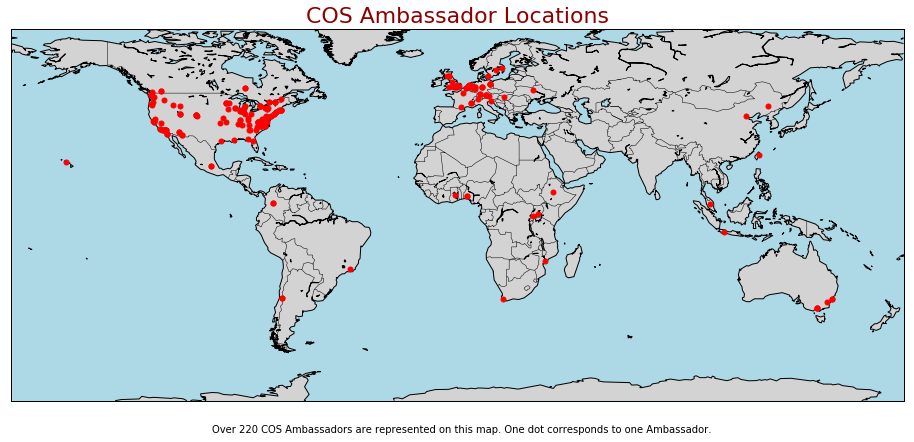

In [16]:
#make the figure bigger
plt.figure(figsize=(16,12))

#setting up map details like type of map (aka 'projection')
my_map = Basemap(projection='cyl', llcrnrlat=-75,urcrnrlat=75,
            llcrnrlon=-180, urcrnrlon=180, resolution='c', area_thresh=1000.0)

#draws continents and coastlines
my_map.drawcoastlines()
#draws countries
my_map.drawcountries()
#fills in continents with color
my_map.fillcontinents(color='lightgray',lake_color='lightblue')
#cleans up map boundary and fills the ocean color
my_map.drawmapboundary(fill_color='lightblue')
#sets x to be longitude and y to be latitude
x,y = my_map(lons, lats)
#plots lat & lon 
my_map.plot(x, y, 'ro', markersize=5)

font_title = {'family': 'sans-serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 22,
        }

plt.title("COS Ambassador Locations", fontdict=font_title)
plt.figtext(0.3,0.25, "Over 220 COS Ambassadors are represented on this map. One dot corresponds to one Ambassador.")
plt.savefig('ambassador_locations.png')
plt.show()

### Part 2: Let's Make an Interactive Map!


In [17]:
import folium 

In [18]:
#remember that CSV we saved earlier? I want to use it here. 
df = pd.read_csv('ambassadors_list_shortened.csv')

#let's see what our data look like
df.head()

,City,State,Country,Full Address,Longitude,Latitude,Region,Institution/Organization,Domain
0,Bonn,NaN,Germany,"Bonn, Germany",7.098207,50.737430,Europe,MPI Collective Goods,Psychology
1,Eindhoven,NaN,Netherlands,"Eindhoven, Netherlands",5.469722,51.441642,Europe,Eindhoven,Psychology
2,Grenoble,NaN,France,"Grenoble, France",5.724524,45.188529,Europe,Université Grenoble Alpes,Psychology
3,Riverside,California,USA,"Riverside, California, USA",-117.375494,33.980601,North America,University of California - Riverside,Psychology
4,Tacoma,Washington,USA,"Tacoma, Washington, USA",-122.444291,47.252877,North America,Pacific Lutheran,Psychology


In [19]:
#for the interactive map I want to create, I need three pieces of info: latitude, longitude, and address
#I create lists for latitude, longitude, and address
lat = list(df['Latitude'])
lon = list(df['Longitude'])
location = list(df['Full Address'])

#printed the first entry in my dataset to make sure it is what I anticipated
print(location[0])
print(lon[0])
print(lat[0])



Bonn, Germany
7.0982068
50.737429999999996


In [20]:
map = folium.Map(location=[0,0], #latitude and longitude of where my map is centered when it loads on the screen
    tiles='CartoDB positron', #type of map projection
    zoom_start=1.5, #bigger zoom number, the closer in it will be 
    max_zoom=10)


for lat, lon, location in zip(lat, lon, location):
    folium.CircleMarker(location=[lat, lon], 
                       radius = 2,
                       color = 'blue',
                       popup = location).add_to(map)



In [21]:
#save our map as an html file 
map.save("ambassador_locations_map.html")

#let's see what our map looks like.
map